# Example 3: Efficient frontier

In this example we will show how to compute efficient frontiers using the `MeanRisk` and `NearOptimalCentering` estimators.

In [1]:
using PortfolioOptimisers, PrettyTables
# Format for pretty tables.
tsfmt = (v, i, j) -> begin
    if j == 1
        return Date(v)
    else
        return v
    end
end;
resfmt = (v, i, j) -> begin
    if j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;

## 1. ReturnsResult data

We will use the same data as the previous example.

In [2]:
using CSV, TimeSeries, DataFrames

X = TimeArray(CSV.File(joinpath(@__DIR__, "SP500.csv.gz")); timestamp = :Date)[(end - 252):end]
pretty_table(X[(end - 5):end]; formatters = tsfmt)

# Compute the returns
rd = prices_to_returns(X)

┌────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│  timestamp │    AAPL │     AMD │     BAC │     BBY │     CVX │      GE │      HD │     JNJ │     JPM │      KO │     LLY │     MRK │    MSFT │     PEP │     PFE │      PG │     RRC │     UNH │     WMT │     XOM │
│ Dates.Date │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 2022-12-20 │ 131.916 │   65.05 │  31.729 │  77.371 │ 169.497 │  62.604 │ 310.342 │ 173.109 │ 127.844 │  61.841 │  357.55 │ 108.229 │  240.

ReturnsResult
    nx | 20-element Vector{String}
     X | 252×20 Matrix{Float64}
    nf | nothing
     F | nothing
    ts | 252-element Vector{Dates.Date}
    iv | nothing
  ivpa | nothing


## 2. Efficient frontier

We have two mutually exclusive ways to compute the efficient frontier. We can do so from the perspective of minimising the risk with a return lower bound, or maximising the return with a risk upper bound. It is possible to provide explicit bounds, or a `Frontier` object which automatically computes the bounds based on the problem and constraints. All four combinations have their use cases. In this example we will only show the use of `Frontier` as a lower bound on the portfolio return.

Since we will be performing various optimistions, we will provide a vector of solver settings because we don't know if a single set of settings will work in all cases.

In [3]:
using Clarabel
slv = [Solver(; name = :clarabel1, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false),
              check_sol = (; allow_local = true, allow_almost = true)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.75),
              check_sol = (; allow_local = true, allow_almost = true))]

2-element Vector{Solver{Symbol, UnionAll, T3, @NamedTuple{allow_local::Bool, allow_almost::Bool}, Bool} where T3}:
 Solver
         name | Symbol: :clarabel1
       solver | UnionAll: Clarabel.MOIwrapper.Optimizer
     settings | Dict{String, Bool}: Dict{String, Bool}("verbose" => 0)
    check_sol | @NamedTuple{allow_local::Bool, allow_almost::Bool}: (allow_local = true, allow_almost = true)
  add_bridges | Bool: true

 Solver
         name | Symbol: :clarabel2
       solver | UnionAll: Clarabel.MOIwrapper.Optimizer
     settings | Dict{String, Real}: Dict{String, Real}("verbose" => false, "max_step_fraction" => 0.75)
    check_sol | @NamedTuple{allow_local::Bool, allow_almost::Bool}: (allow_local = true, allow_almost = true)
  add_bridges | Bool: true


This time we will use the `ConditionalValueatRisk` measure and we will once again precompute prior.

In [4]:
r = ConditionalValueatRisk()
pr = prior(EmpiricalPrior(), rd)

LowOrderPrior
        X | 252×20 Matrix{Float64}
       mu | 20-element Vector{Float64}
    sigma | 20×20 Matrix{Float64}
     chol | nothing
        w | nothing
      ens | nothing
      kld | nothing
       ow | nothing
       rr | nothing
     f_mu | nothing
  f_sigma | nothing
      f_w | nothing


Lets create the efficient frontier by setting returns lower bounds and minimising the risk. We will compute a 30-point frontier.

In [5]:
opt = JuMPOptimiser(; pe = pr, slv = slv, ret = ArithmeticReturn(; lb = Frontier(; N = 30)))

JuMPOptimiser
      pe | LowOrderPrior
         |         X | 252×20 Matrix{Float64}
         |        mu | 20-element Vector{Float64}
         |     sigma | 20×20 Matrix{Float64}
         |      chol | nothing
         |         w | nothing
         |       ens | nothing
         |       kld | nothing
         |        ow | nothing
         |        rr | nothing
         |      f_mu | nothing
         |   f_sigma | nothing
         |       f_w | nothing
     slv | Vector{Solver{Symbol, UnionAll, T3, @NamedTuple{allow_local::Bool, allow_almost::Bool}, Bool} where T3}: Solver{Symbol, UnionAll, T3, @NamedTuple{allow_local::Bool, allow_almost::Bool}, Bool} where T3[Solver
         name | Symbol: :clarabel1
       solver | UnionAll: Clarabel.MOIwrapper.Optimizer
     settings | Dict{String, Bool}: Dict{String, Bool}("verbose" => 0)
    check_sol | @NamedTuple{allow_local::Bool, allow_almost::Bool}: (allow_local = true, allow_almost = true)
  add_bridges | Bool: true
, Solver
         name 

We can now use `opt` to create the `MeanRisk` estimator. In order to get the entire frontier, we need to minimise the risk (which is the default value).

In [6]:
mr = MeanRisk(; opt = opt, r = r)
res1 = optimise!(mr)

JuMPOptimisation
       oe | DataType: MeanRisk
       pa | ProcessedJuMPOptimiserAttributes
          |       pr | LowOrderPrior
          |          |         X | 252×20 Matrix{Float64}
          |          |        mu | 20-element Vector{Float64}
          |          |     sigma | 20×20 Matrix{Float64}
          |          |      chol | nothing
          |          |         w | nothing
          |          |       ens | nothing
          |          |       kld | nothing
          |          |        ow | nothing
          |          |        rr | nothing
          |          |      f_mu | nothing
          |          |   f_sigma | nothing
          |          |       f_w | nothing
          |       wb | WeightBounds
          |          |   lb | 20-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
          |          |   ub | 20-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
          

Note that `retcode` and `sol` are now vectors. This is because there is one per point in the frontier. Since we didn't get any warnings that any optimisations failed we can proceed without checking the return codes. Regardless, lets check that all optimisations succeeded.

In [7]:
all(x -> isa(x, OptimisationSuccess), res1.retcode)

true

We can view how the weights evolve along the frontier.

In [8]:
pretty_table(DataFrame([rd.nx hcat(res1.w...)], Symbol.([:assets; 1:30]));
             formatters = resfmt)

┌────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬─────────┬─────────┬─────────┐
│ assets │        1 │        2 │        3 │        4 │        5 │        6 │        7 │        8 │        9 │       10 │       11 │       12 │       13 │       14 │       15 │       16 │       17 │       18 │       19 │       20 │       21 │       22 │       23 │       24 │       25 │       26 │       27 │      28 │      29 │      30 │
│    Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │      Any │     Any │     An

## 3. Visualising the efficient frontier

Perhaps it is time to introduce some visualisations, which are implemented as a package extesion. For this we need to import the `Plots` and `GraphRecipes` packages.

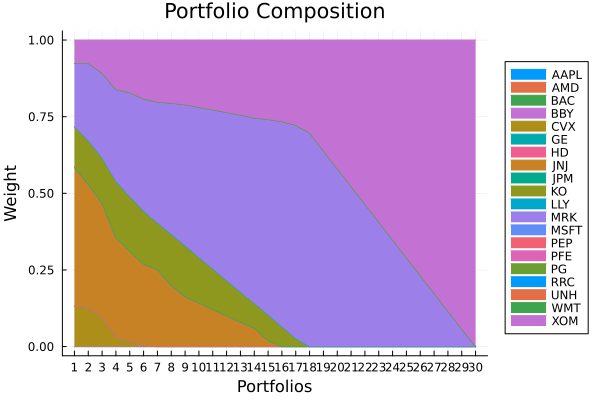

In [9]:
using StatsPlots, GraphRecipes

plot_stacked_area_composition(res1.w, rd.nx)

The efficient frontier is just a special case of a pareto front, we have a function that can plot pareto fronts and surfaces. We have to provide the weights and the prior. There are optional keyword parameters for the risk measure for the X-axis, Y-axis, Z-axis, and colourbar. Here we will use the Conditional Value at Risk as the X-axis, the arithmetic return, and the risk-return ratio as the colourbar.

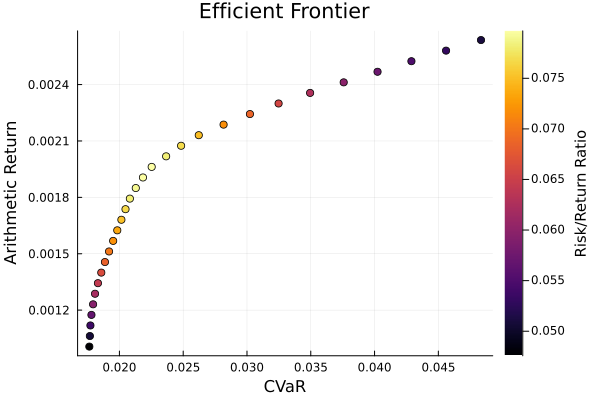

In [10]:
# Risk-free rate of 4.2/100/252
plot_measures(res1.w, res1.pr; x = r, y = ReturnRiskMeasure(; rt = res1.ret),
              c = RatioRiskMeasure(; rt = res1.ret, rk = r, rf = 4.2 / 100 / 252),
              title = "Efficient Frontier", xlabel = "CVaR", ylabel = "Arithmetic Return",
              colorbar_title = "\nRisk/Return Ratio", right_margin = 6Plots.mm)

The `plot_measures` function can plot all sorts of pareto fronts. We can even use the ratio of two risk measures as the colourbar.

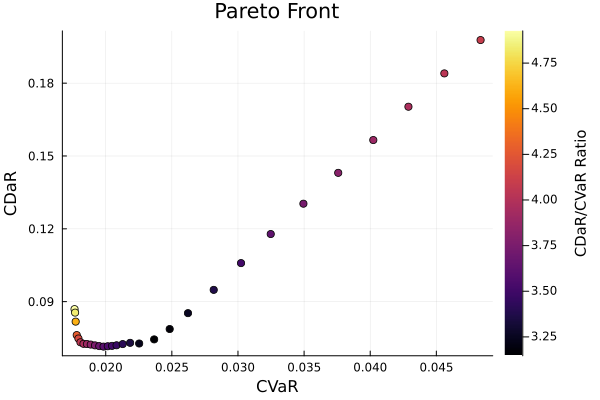

In [11]:
plot_measures(res1.w, res1.pr; x = r, y = ConditionalDrawdownatRisk(),
              c = RiskRatioRiskMeasure(; r1 = ConditionalDrawdownatRisk(), r2 = r),
              title = "Pareto Front", xlabel = "CVaR", ylabel = "CDaR",
              colorbar_title = "\nCDaR/CVaR Ratio", right_margin = 6Plots.mm)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*